<a href="https://colab.research.google.com/github/kelynz/itd214proj/blob/main/3988288G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preparation


### Data Source & Description

#### Kaggle Data Source
https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews/data

**About Dataset**

This dataset was collected via Python scraper in March 2023 and contains:

information about all beauty products (over 8,000) from the Sephora online store, including product and brand names, prices, ingredients, ratings, and all features.
user reviews (about 1 million on over 2,000 products) of all products from the Skincare category, including user appearances, and review ratings by other users

#### Dataset Name: Products
Target Variable:
* loves_count: The number of people who have marked this product as a favorite

#### Other Attributes Information
* product_id: The unique identifier for the product from the site
* product_name: The full name of the product
* brand_id: The unique identifier for the product brand from the site
* brand_name: The full name of the product brand (categorical)
* rating: The average rating of the product based on user reviews (continuous)
* reviews: The number of user reviews for the product (continuous)
* size: The size of the product, which may be in oz, ml, g, packs, or other units depending on the product type
* variation_type: The type of variation parameter for the product (e.g. Size, Color)
* variation_value: The specific value of the variation parameter for the product (e.g. 100 mL, Golden Sand)
* variation_desc: A description of the variation parameter for the product (e.g. tone for fairest skin)
* ingredients: A list of ingredients included in the product, for example: [‘Product variation 1:’, ‘Water, Glycerin’, ‘Product variation 2:’, ‘Talc, Mica’] or if no variations [‘Water, Glycerin’]
* price_usd: The price of the product in US dollars
* value_price_usd: The potential cost savings of the product, presented on the site next to the regular price
* sale_price_usd: The sale price of the product in US dollars
* limited_edition: Indicates whether the product is a limited edition or not (1-true, 0-false)  
* new: Indicates whether the product is new or not (1-true, 0-false)
* online_only: Indicates whether the product is only sold online or not (1-true, 0-false)  
* out_of_stock: Indicates whether the product is currently out of stock or not (1 if true, 0 if false)  
* sephora_exclusive: Indicates whether the product is exclusive to Sephora or not (1 if true, 0 if false)  
* highlights: A list of tags or features that highlight the product's attributes (e.g. [‘Vegan’, ‘Matte Finish’])
* primary_category: First category in the breadcrumb section
* secondary_category: Second category in the breadcrumb section
* tertiary_category: Third category in the breadcrumb section
* child_count: The number of variations of the product available  
* child_max_price: The highest price among the variations of the product
* child_min_price: The lowest price among the variations of the product

#### Objective
To identify the key factors driving high loves_count within each product category, enabling the marketing strategy team to make more informed decisions—such as implementing bundle sales, cross-selling opportunities, and other targeted promotional tactics.

### Libraries & Loading Data

In [ ]:
!pip install fuzzywuzzy python-Levenshtein
from fuzzywuzzy import process

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler

In [ ]:
df_product = pd.read_csv('product_info.csv')

### Data Description

In [ ]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [ ]:
missing_values = df_product.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    missing_percentage = (missing_values / len(df_product)) * 100
    missing_info = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage (%)': missing_percentage})
    missing_info = missing_info.sort_values(by='Missing Percentage (%)', ascending=False)
    print("Columns with Missing Values:")
    display(missing_info)
else:
    print("No missing values found in the DataFrame.")

Columns with Missing Values:


,Missing Count,Missing Percentage (%)
sale_price_usd,8224,96.821286
value_price_usd,8043,94.690370
variation_desc,7244,85.283730
child_max_price,5740,67.577113
child_min_price,5740,67.577113
highlights,2207,25.983047
size,1631,19.201789
variation_value,1598,18.813280
variation_type,1444,17.000235
tertiary_category,990,11.655286


In [ ]:
df_product.describe()

,brand_id,loves_count,rating,reviews,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price
count,8494.000000,8.494000e+03,8216.000000,8216.000000,8494.000000,451.000000,270.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,2754.000000,2754.000000
mean,5422.440546,2.917957e+04,4.194513,448.545521,51.655595,91.168537,20.207889,0.070285,0.071698,0.219096,0.073699,0.279374,1.631622,53.792023,39.665802
std,1709.595957,6.609212e+04,0.516694,1101.982529,53.669234,79.195631,24.327352,0.255642,0.258002,0.413658,0.261296,0.448718,5.379470,58.765894,38.685720
min,1063.000000,0.000000e+00,1.000000,1.000000,3.000000,0.000000,1.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
25%,5333.000000,3.758000e+03,3.981725,26.000000,25.000000,45.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,19.000000
50%,6157.500000,9.880000e+03,4.289350,122.000000,35.000000,67.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,28.000000
75%,6328.000000,2.684125e+04,4.530525,418.000000,58.000000,108.500000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,59.000000,42.000000
max,8020.000000,1.401068e+06,5.000000,21281.000000,1900.000000,617.000000,320.000000,1.000000,1.000000,1.000000,1.000000,1.000000,105.000000,570.000000,400.000000


In [ ]:
print ("Rows     : " ,df_product.shape[0])
print ("Columns  : " ,df_product.shape[1])
print ("\nFeatures : \n" ,df_product.columns.tolist())
print ("\nMissing values :  ", df_product.isnull().sum().values.sum())
print ("\nUnique values :  \n",df_product.nunique())

Rows     :  8494
Columns  :  27

Features : 
 ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price']

Missing values :   44370

Unique values :  
 product_id            8494
product_name          8415
brand_id               304
brand_name             304
loves_count           7436
rating                4394
reviews               1556
size                  2055
variation_type           7
variation_value       2729
variation_desc         935
ingredients           6538
price_usd              298
value_price_usd        174
sale_price_usd          88
limited_edition          2
new                      2
online_only         

In [ ]:
categorical_cols = df_product.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"Column: {col}")
    print(f"Number of unique values: {df_product[col].nunique()}")
    print(f"Unique values: {df_product[col].unique()}")
    print("-" * 30)

Column: product_id
Number of unique values: 8494
Unique values: ['P473671' 'P473668' 'P473662' ... 'P504428' 'P504448' 'P505461']
------------------------------
Column: product_name
Number of unique values: 8415
Unique values: ['Fragrance Discovery Set' 'La Habana Eau de Parfum'
 'Rainbow Bar Eau de Parfum' ... 'Mon Paris Eau de Parfum Gift Set'
 'Y Eau de Parfum Gift Set'
 'Candy Glaze Lip Gloss Stick Duo with Hyaluronic Acid']
------------------------------
Column: brand_name
Number of unique values: 304
Unique values: ['19-69' '54 Thrones' 'ABBOTT' 'Acqua di Parma' 'adwoa beauty' 'AERIN'
 'Algenist' 'Alpha-H' 'alpyn beauty' 'ALTERNA Haircare' 'Ami Colé' 'amika'
 'Anastasia Beverly Hills' 'Aquis' 'Armani Beauty' 'Artist Couture'
 'Atelier Cologne' 'Augustinus Bader' 'Azzaro' 'bareMinerals' 'BeautyBio'
 'beautyblender' 'belif' 'Benefit Cosmetics' 'BERDOUES' 'Bio Ionic'
 'Biossance' 'Blinc' 'Bobbi Brown' 'Bon Parfumeur' 'BondiBoost'
 'Boy Smells' 'BREAD BEAUTY SUPPLY' 'Briogeo' 'Bumble

In [ ]:
primary_cat_counts = df_product['primary_category'].value_counts()
primary_cat_percentages = df_product['primary_category'].value_counts(normalize=True) * 100

primary_cat_distribution = pd.DataFrame({
    'Count': primary_cat_counts,
    'Percentage': primary_cat_percentages
})

print("Primary Category Distribution:")
print(primary_cat_distribution)

Primary Category Distribution:
                  Count  Percentage
primary_category                   
Skincare           2420   28.490699
Makeup             2369   27.890275
Hair               1464   17.235696
Fragrance          1432   16.858959
Bath & Body         405    4.768072
Mini Size           288    3.390629
Men                  60    0.706381
Tools & Brushes      52    0.612197
Gifts                 4    0.047092


In [ ]:
for primary_cat in df_product['primary_category'].unique():
    print(f"Primary Category: {primary_cat}")
    secondary_cat_counts = df_product[df_product['primary_category'] == primary_cat]['secondary_category'].value_counts()
    secondary_cat_percentages = df_product[df_product['primary_category'] == primary_cat]['secondary_category'].value_counts(normalize=True) * 100

    secondary_cat_distribution = pd.DataFrame({
        'Count': secondary_cat_counts,
        'Percentage': secondary_cat_percentages
    })

    print(secondary_cat_distribution)
    print("-" * 30)

Primary Category: Fragrance
                       Count  Percentage
secondary_category                      
Women                    875   61.188811
Candles & Home Scents    262   18.321678
Value & Gift Sets        155   10.839161
Men                      135    9.440559
Mini Size                  3    0.209790
------------------------------
Primary Category: Bath & Body
                       Count  Percentage
secondary_category                      
Body Moisturizers        220   54.320988
Bath & Shower             84   20.740741
Body Care                 69   17.037037
Self Tanners              11    2.716049
Value & Gift Sets         10    2.469136
Mini Size                  7    1.728395
Beauty Supplements         2    0.493827
Candles & Home Scents      1    0.246914
Sunscreen                  1    0.246914
------------------------------
Primary Category: Mini Size
                    Count  Percentage
secondary_category                   
Makeup                137   47.735192


In [ ]:
secondary_to_primary = df_product.groupby('secondary_category')['primary_category'].unique()
print("Distinct Primary Categories for each Secondary Category:")
print(secondary_to_primary)

Distinct Primary Categories for each Secondary Category:
secondary_category
Accessories                                                           [Makeup]
Bath & Body                                                        [Mini Size]
Bath & Shower                                                    [Bath & Body]
Beauty Accessories                                           [Tools & Brushes]
Beauty Supplements                                               [Bath & Body]
Beauty Tools                                                 [Tools & Brushes]
Body Care                                                        [Bath & Body]
Body Moisturizers                                                [Bath & Body]
Brushes & Applicators                                [Makeup, Tools & Brushes]
Candles & Home Scents                                 [Fragrance, Bath & Body]
Cheek                                                                 [Makeup]
Cleansers                                              

### Data Cleaning and Correction

#### Cleaning up from the primary_category level first
* "Mini Size" existed as secondary_category in other categories e.g. Makeup. And the secondary_category except "Value & Gift Sets" is actually same as other primary_category. Henceforth, I have swopped the primary_category and secondary_category of these products.
  * "Fragrance" goes under "Fragrance" -> "Mini Size"
  * "Skincare" goes under "Skincare" -> "Mini Size"
  * "Hair" goes under "Hair" -> "Mini Size"
  * "Makeup" goes under "Makeup" -> "Mini Size"
  * "Bath & Body" goes under "Bath & Body" -> "Mini Size"
  * "Value & Gift Sets" is also a secondary_category under the other main primary_category. Unlike the rest where I can infer from secondary_category, as there are only 6 records, I decide to print out the records to determine the category.

* "Tools & Brushes" are subset of the "Hair" and "Makeup" base on domain knowledge hence re-categorizing accordingly
   * "Hair Tools" goes under "Hair" -> "Tools"
   * "Brushes & Applicators" goes under "Makeup" -> "Brushes & Applicators"
   * "Beauty Tools" and "Beauty Accessories" goes under "Makeup" -> "Accessories"

* "Men" has limited and low engagement, inclusion of this category may introduce noise due to sparse data, likely to consider to drop this to focus on core consumer segments e.g. women buyers

* "Gifts" refers to giftcards or store credits, as these are intermediary financial instruments and not physical products with attributes like size, brand, category, it does not reflect product desirability, hence will drop this since it does not align with the objective.

In [ ]:
# Identify the row with the specific product_id
mask = df_product['product_id'] == 'P445725'
# Swap primary and secondary categories and set primary_category to 'Makeup'
df_product.loc[mask, ['primary_category', 'secondary_category']] = df_product.loc[mask, ['secondary_category', 'primary_category']].values
df_product.loc[mask, 'primary_category'] = 'Makeup'

In [ ]:
# Swap primary and secondary categories for 'Mini Size' excluding 'Value & Gift Sets'
mask = (df_product['primary_category'] == 'Mini Size') & (df_product['secondary_category'] != 'Value & Gift Sets')
df_product.loc[mask, ['primary_category', 'secondary_category']] = df_product.loc[mask, ['secondary_category', 'primary_category']].values

In [ ]:
mini_size_gift_sets_df = df_product[(df_product['primary_category'] == 'Mini Size') & (df_product['secondary_category'] == 'Value & Gift Sets')]
display(mini_size_gift_sets_df)

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
581,P502233,Mini Roller Express Curling Mascara & Liquid E...,5333,Benefit Cosmetics,7264,4.600,5.0,NaN,NaN,NaN,...,1,1,0,"['Volumizing', 'Long-wearing']",Mini Size,Value & Gift Sets,NaN,0,NaN,NaN
595,P505033,Mini The POREfessional Package Deal pore prime...,5333,Benefit Cosmetics,539,NaN,NaN,NaN,NaN,NaN,...,0,0,0,"['Liquid Formula', 'Good for: Pores']",Mini Size,Value & Gift Sets,NaN,0,NaN,NaN
3813,P502307,Mini Blush & Bloom Cheek and Lip Tint Set,6254,Jouer Cosmetics,5122,3.500,4.0,NaN,NaN,NaN,...,1,0,0,"['Vegan', 'Stick Formula', 'Hydrating', 'Matte...",Mini Size,Value & Gift Sets,NaN,0,NaN,NaN
5291,P503582,Mini Shine On Dolce Vita Lip Duo Set,3976,NARS,18880,4.625,8.0,NaN,NaN,NaN,...,0,1,0,"['High Shine Finish', 'Matte Finish', 'Without...",Mini Size,Value & Gift Sets,NaN,0,NaN,NaN
7887,P502503,Mini Secret Santa Eyeshadow Palette,4225,Too Faced,15161,4.200,10.0,NaN,NaN,NaN,...,1,1,0,"['Pressed Powder Formula', 'Metallic Finish', ...",Mini Size,Value & Gift Sets,NaN,0,NaN,NaN
8327,P477455,Mini Decorative Tin Trio,6245,VOLUSPA,1048,2.500,2.0,NaN,NaN,NaN,...,0,1,1,"['Vegan', 'Without Phthalates', 'Without Parab...",Mini Size,Value & Gift Sets,NaN,0,NaN,NaN


In [ ]:
# Change categories for P477455
mask = df_product['product_id'] == 'P477455'
df_product.loc[mask, 'primary_category'] = 'Fragrance'

# Change categories for the rest of the 'Value & Gift Sets' records (excluding index 8327)
mask = (df_product['primary_category'] == 'Mini Size') & (df_product['secondary_category'] == 'Value & Gift Sets') & (df_product.index != 8327)
df_product.loc[mask, 'primary_category'] = 'Makeup'

In [ ]:
# Change categories for 'Tools & Brushes' primary_category and 'Hair Tools' secondary_category
mask = (df_product['primary_category'] == 'Tools & Brushes') & (df_product['secondary_category'] == 'Hair Tools')
df_product.loc[mask, 'primary_category'] = 'Hair'
df_product.loc[mask, 'secondary_category'] = 'Tools'

# Change categories for 'Tools & Brushes' primary_category and 'Brushes & Applicators' secondary_category
mask = (df_product['primary_category'] == 'Tools & Brushes') & (df_product['secondary_category'] == 'Brushes & Applicators')
df_product.loc[mask, 'primary_category'] = 'Makeup'

# Change categories for 'Tools & Brushes' primary_category and 'Beauty Tools' secondary_category
mask = (df_product['primary_category'] == 'Tools & Brushes') & (df_product['secondary_category'] == 'Beauty Tools')
df_product.loc[mask, 'primary_category'] = 'Makeup'
df_product.loc[mask, 'secondary_category'] = 'Accessories'

# Change categories for 'Tools & Brushes' primary_category and 'Beauty Accessories' secondary_category
mask = (df_product['primary_category'] == 'Tools & Brushes') & (df_product['secondary_category'] == 'Beauty Accessories')
df_product.loc[mask, 'primary_category'] = 'Makeup'
df_product.loc[mask, 'secondary_category'] = 'Accessories'

#### Cleaning up from the secondary_category level

* Under "Bath & Body" primary_category, noticed there are some secondary_category records more suitable to be categorize under another primary_category henceforth recategorize them accordingly.

* Luckily, "Shop by concern" secondary_category has only 5 records henceforth we can manually check and determine the rightful secondary_category by referring to similar products base on product name

In [ ]:
# Change categories for 'Bath & Body' primary category, 'Self Tanners' secondary category to 'Skincare'
mask = (df_product['primary_category'] == 'Bath & Body') & (df_product['secondary_category'] == 'Self Tanners')
df_product.loc[mask, 'primary_category'] = 'Skincare'

# Change categories for 'Bath & Body' primary category, 'Sunscreen' secondary category to 'Skincare'
mask = (df_product['primary_category'] == 'Bath & Body') & (df_product['secondary_category'] == 'Sunscreen')
df_product.loc[mask, 'primary_category'] = 'Skincare'

# Change categories for 'Bath & Body' primary category, 'Beauty Supplements' secondary category to 'Skincare' and 'Wellness'
mask = (df_product['primary_category'] == 'Bath & Body') & (df_product['secondary_category'] == 'Beauty Supplements')
df_product.loc[mask, 'primary_category'] = 'Skincare'
df_product.loc[mask, 'secondary_category'] = 'Wellness'

# Change categories for 'Bath & Body' primary category, 'Candles & Home Scents' secondary category to 'Fragrance'
mask = (df_product['primary_category'] == 'Bath & Body') & (df_product['secondary_category'] == 'Candles & Home Scents')
df_product.loc[mask, 'primary_category'] = 'Fragrance'

In [ ]:
# Change secondary_category to "Mini Size" for specified product IDs
mini_size_product_ids = ['P427715', 'P429538']
df_product.loc[df_product['product_id'].isin(mini_size_product_ids), 'secondary_category'] = 'Mini Size'

# Change secondary_category to "Hair Styling Products" for specified product IDs
hair_styling_product_ids = ['P415754', 'P437299', 'P430845']
df_product.loc[df_product['product_id'].isin(hair_styling_product_ids), 'secondary_category'] = 'Hair Styling & Treatments'

#### Cleaning up size
* Using regular expression to split up the size to "size_unit" and "size_value"
* Then convert fl oz to ml, oz to g and others e.g. pcs/capsules will be generalize as "unit"
* So eventually size_unit will only have ml, g, unit or unknown (if value is empty)

In [ ]:
def categorize_size_unit_end(size_str):
    if pd.isna(size_str):
        return 'Unknown', None, None
    size_str_lower = str(size_str).strip().lower()

    # Split the string by the rightmost slash and take the last part
    parts = size_str_lower.rsplit('/', 1)
    part_to_categorize = parts[-1].strip() # Take the last part

    # Check for primary units in the last part
    match_primary = re.search(r'(\d+\.?\d*)\s*(ml|oz|g|fl oz)', part_to_categorize)
    if match_primary:
        value = float(match_primary.group(1))
        unit = match_primary.group(2)
        return unit, value, unit # Return the unit itself as the category

    else:
        # Check for the pattern (\d+\.?\d*)\s* followed by something else in the last part
        match_other_unit = re.search(r'(\d+\.?\d*)\s*(.+)', part_to_categorize)
        if match_other_unit:
            value = float(match_other_unit.group(1))
            unit_part = match_other_unit.group(2).strip()

            # Trim units that start with base units followed by other words (already handled in extract_size_and_unit, but for categorization consistency)
            if unit_part.startswith('ml '):
                 unit = 'ml'
            elif unit_part.startswith('oz '):
                 unit = 'oz'
            elif unit_part.startswith('g '):
                 unit = 'g'
            elif unit_part.startswith('fl oz '):
                 unit = 'fl oz'
            # If the unit part is not one of the primary units and doesn't start with a base unit followed by words, categorize as 'unit'
            elif unit_part not in ['ml', 'oz', 'g', 'fl oz']:
                 return 'unit', value, unit_part # Return 'unit' as category, and original unit_part

            return unit, value, unit # Return the base unit, value, and base unit

    return 'Unknown', None, None # Default category, value, and unit if none of the above match

# Apply the function to the 'size' column and create new columns in df_product
df_product[['size_unit', 'size_value', 'size_unit_exploratory']] = df_product['size'].apply(lambda x: pd.Series(categorize_size_unit_end(x)))


In [ ]:
# Identify rows to convert
fl_oz_mask = df_product['size_unit'] == 'fl oz'
oz_mask = df_product['size_unit'] == 'oz'

# Perform the conversions and update the original columns
# Convert fl oz to ml
df_product.loc[fl_oz_mask, 'size_value'] = df_product.loc[fl_oz_mask, 'size_value'] * 29.57 # Approximate conversion
df_product.loc[fl_oz_mask, 'size_unit'] = 'ml'

# Convert oz to g
df_product.loc[oz_mask, 'size_value'] = df_product.loc[oz_mask, 'size_value'] * 28.35 # Approximate conversion
df_product.loc[oz_mask, 'size_unit'] = 'g'

In [ ]:
# print("Distribution of Size Categories based on Unit End (Exploratory):")
print(df_product['size_unit'].value_counts())

size_unit
ml         5145
Unknown    1649
g          1501
unit        199
Name: count, dtype: int64


In [ ]:
print("\nInfo of the cleaned DataFrame:")
df_product.info()


Info of the cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             8494 non-null   object 
 1   product_name           8494 non-null   object 
 2   brand_id               8494 non-null   int64  
 3   brand_name             8494 non-null   object 
 4   loves_count            8494 non-null   int64  
 5   rating                 8216 non-null   float64
 6   reviews                8216 non-null   float64
 7   size                   6863 non-null   object 
 8   variation_type         7050 non-null   object 
 9   variation_value        6896 non-null   object 
 10  variation_desc         1250 non-null   object 
 11  ingredients            7549 non-null   object 
 12  price_usd              8494 non-null   float64
 13  value_price_usd        451 non-null    float64
 14  sale_price_usd         2

#### Further cleansing

**Dropped records**
*   primary_category in Gifts or Men

**Dropped columns**
*   product_id - drop identifier
*   product_name - drop identifier
*   brand_id - drop identifier
*   value_price_usd - many empty value
*   sale_price_usd - many empty value
*   child_min_price - many empty value
*   child_max_price - many empty value

**size_unit**
*   size_unit - one-hot encode

**brand_name**
*   brand_name - check for similar brand name due to mispell or so. if not, then apply target encoding (no increase in feature dimensonality)

**reviews and rating**
As both reviews and rating have **same missing entries**, which suggests likely missing together (no one reviewed hence no rating), hence...
*   reviews - impute missing values with 0, assumption is missing values means no reviews
*   rating - add a new feature "has_rating" (binary) to differentiate those with no review vs those with review. Then impute missing values as 0.

**Numerical values: loves_count, price_usd, reviews, ratings**
*   loves_count - log due to right skewness
*   price_usd - log due to right skewness
*   reviews - log due to right skewness

**variation_type**

Note: size type will be ignored as the size feature has already been cleaned up using the "size" column
*   Added has_color
*   Added has_scent
*   Added has_formulation
*   Added has_type

**highlight** -- Removed. Tested without this the model improves
*   This is a structured list storing product tags so will extracted the top 50 features to use as binary features



In [ ]:
# Get unique brand names
brand_names = df_product['brand_name'].unique()

# Set a threshold for similarity (you can adjust this)
threshold = 90

print("Highly similar brand names:")
# Find and print similar brand names
for brand in brand_names:
    matches = process.extract(brand, brand_names, limit=5) # Get top 5 matches
    # Filter out the brand itself and matches below the threshold
    similar_brands = [match[0] for match in matches if match[0] != brand and match[1] >= threshold]
    if similar_brands:
        print(f"- '{brand}': {similar_brands}")

Highly similar brand names:
- 'goop': ['Supergoop!']
- 'ILIA': ['KILIAN Paris']
- 'Josie Maran': ['MARA']
- 'KILIAN Paris': ['ILIA']
- 'MARA': ['Josie Maran']
- 'Supergoop!': ['goop']
- 'The 7 Virtues': ['Virtue']
- 'Virtue': ['The 7 Virtues']


In [ ]:
# Drop Gifts and Men
df_product = df_product[~df_product['primary_category'].isin(['Gifts', 'Men'])]

# Drop the specified columns from the DataFrame
df_product = df_product.drop(columns=['product_id', 'product_name', 'brand_id', 'value_price_usd', 'sale_price_usd', 'child_min_price', 'child_max_price'])

# One-hot encode size_unit
df_product = pd.get_dummies(df_product, columns=['size_unit'], prefix='unit')
bool_cols = df_product.select_dtypes('bool').columns
df_product[bool_cols] = df_product[bool_cols].astype(int)

# Apply target encoding to the 'brand_name' column using the mean loves_count for each brand
df_product['brand_name_encoded'] = df_product.groupby('brand_name')['loves_count'].transform('mean')

# Impute missing values for reviews and rating. Add a new feature "has_rating" to differentiate product without reviews
df_product['reviews'] = df_product['reviews'].fillna(0)
df_product['has_rating'] = df_product['rating'].notna().astype(int)
df_product['rating'] = df_product['rating'].fillna(0)

# Add features from variation_type
non_size_types = ['Color', 'Scent', 'Formulation', 'Type']
for vt in non_size_types:
    df_product[f'has_{vt.lower()}'] = (df_product['variation_type'] == vt).astype(int)

# Combine primary_category and secondary_category and apply frequency encoding
df_product['combined_category'] = df_product['primary_category'].astype(str) + '_' + df_product['secondary_category'].astype(str)
combined_category_counts = df_product['combined_category'].value_counts()
df_product['combined_category_encoded'] = df_product['combined_category'].map(combined_category_counts)

In [ ]:
# # Sample code to expand
# from sklearn.preprocessing import MultiLabelBinarizer
# from collections import Counter

# # Extract list of labels from 'highlights', drop NaN, and convert to lowercase
# highlights_lists = df_product['highlights'].dropna().apply(eval).apply(lambda x: [item.lower() for item in x]).tolist()

# # Flatten to count frequency
# all_labels = [label for sublist in highlights_lists for label in sublist]
# label_counts = Counter(all_labels)

# # Select top N frequent labels
# top_labels = set([label for label, count in label_counts.most_common(50)])

# Filter each list to keep only top labels
# filtered_highlights = df_product['highlights'].dropna().apply(eval).apply(lambda x: [item.lower() for item in x if item.lower() in top_labels])

# Apply MultiLabelBinarizer on filtered highlights
# mlb = MultiLabelBinarizer()
# features = pd.DataFrame(mlb.fit_transform(filtered_highlights), columns=mlb.classes_, index=filtered_highlights.index)

# Add the "highlights_" prefix to the new feature column names
# features.columns = [f"highlights_{col}" for col in features.columns]

# # Join the new features to the main DataFrame
# df_product = df_product.join(features)

# Fill NaN values in the new highlight feature columns with 0
# highlight_columns = [col for col in df_product.columns if col.startswith('highlights_')]
# df_product[highlight_columns] = df_product[highlight_columns].fillna(0)

#### Visualize skewness before deciding to log/standardize

**loves_count**

*   Before log: Extremely right-skewed with a long tail.
*   After log: Nicely bell-shaped and much more symmetrical.
*   Decision: To proceed with log transformation as it reduces skew and improves distribution shape

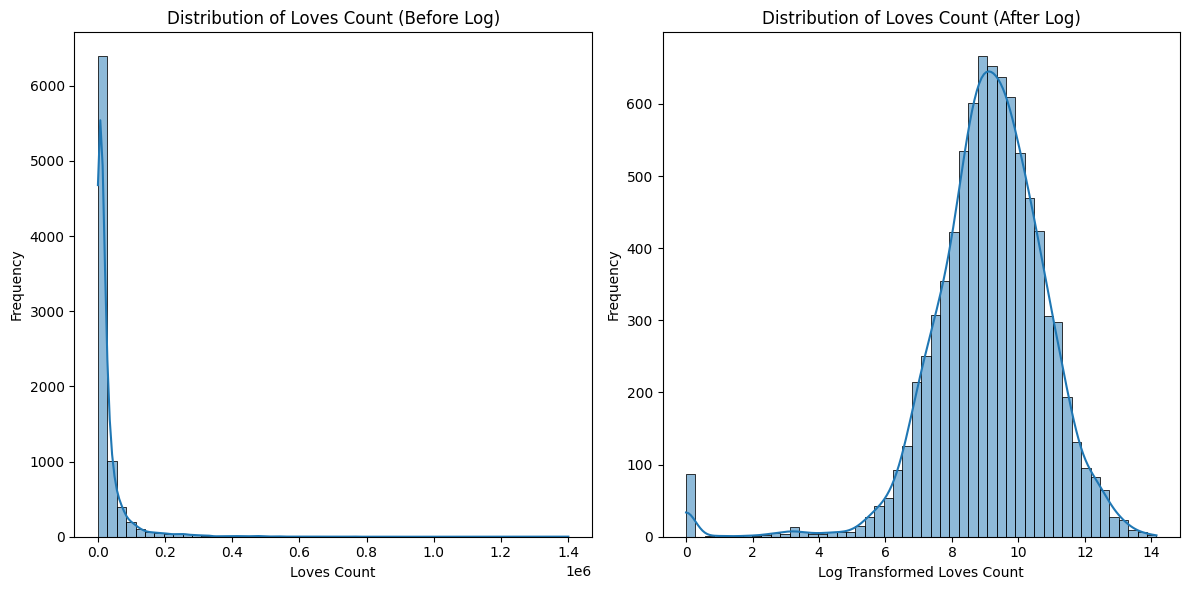

In [ ]:
# Visualize skewness of loves_count before and after log transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_product['loves_count'], bins=50, kde=True)
plt.title('Distribution of Loves Count (Before Log)')
plt.xlabel('Loves Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_product['loves_count']), bins=50, kde=True)
plt.title('Distribution of Loves Count (After Log)')
plt.xlabel('Log Transformed Loves Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**reviews**
*   Before log: Highly skewed and sparse.
*   After log: Still skewed, but significantly improved. Most of the density is now centralized.
*   Decision: Though it is still skewed but the skewness has significantly improved and may help with model learning hence will proceed with log transformation

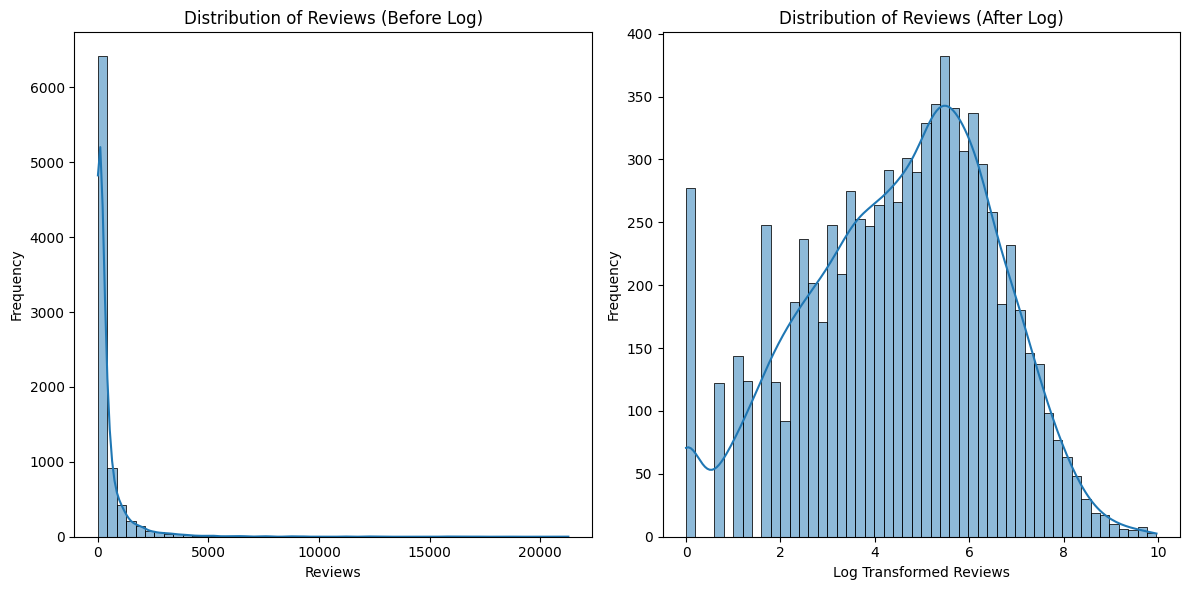

In [ ]:
# Visualize skewness of reviews before and after log transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_product['reviews'], bins=50, kde=True)
plt.title('Distribution of Reviews (Before Log)')
plt.xlabel('Reviews')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_product['reviews']), bins=50, kde=True)
plt.title('Distribution of Reviews (After Log)')
plt.xlabel('Log Transformed Reviews')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**price_usd**
*   Before log: Right-skewed with a few extreme outliers.
*   After log: Symmetrical and much closer to a normal distribution.
*   Decision: Bell curve is centralized and nicely-shaped. To proceed.

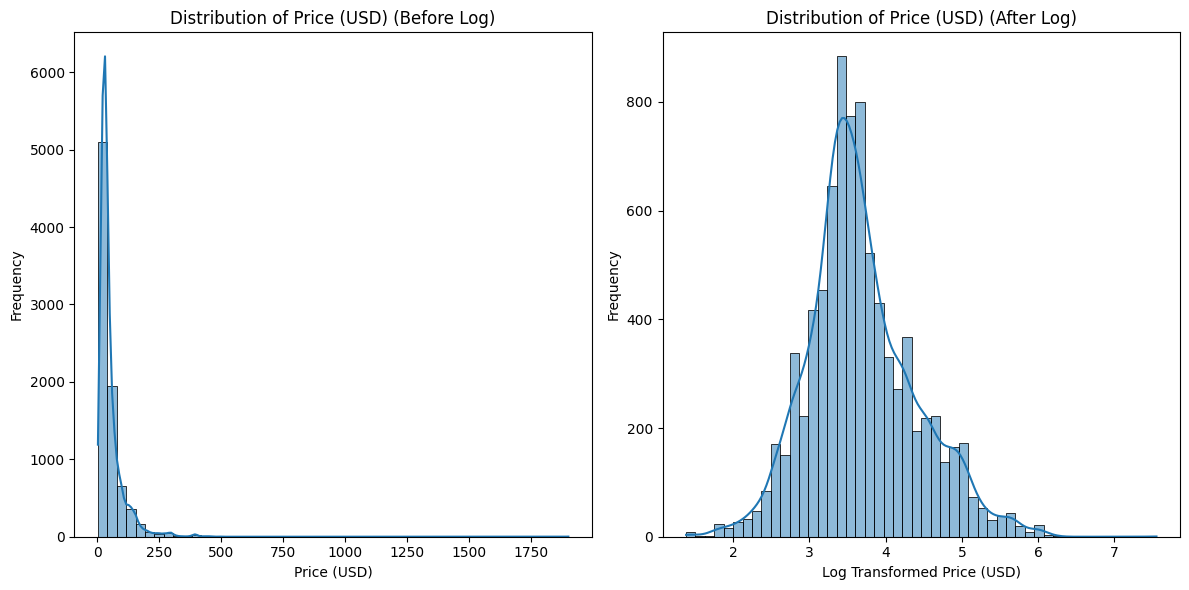

In [ ]:
# Visualize skewness of price_usd before and after log transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_product['price_usd'], bins=50, kde=True)
plt.title('Distribution of Price (USD) (Before Log)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_product['price_usd']), bins=50, kde=True)
plt.title('Distribution of Price (USD) (After Log)')
plt.xlabel('Log Transformed Price (USD)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



size_value
*   Before Log: Strong right-skew, with many small values clustered at the low end and a long tail.
*   After log: Skewness has reduce however the shape is not in normal bell-curve. This could be because of the correlation to the size_unit e.g. g, ml, unit where the units cannot be reconciled with the same measurement to unify as one type of measurement.
*   Decision: Will proceed to log-transform as the intention is to reduce skew, making the model less sensitive to outliers and consistent with other log-transformed features. Moreover, the size_units has been one-hot encoded to teach the model to understand the composite relationship of size_unit and size_value


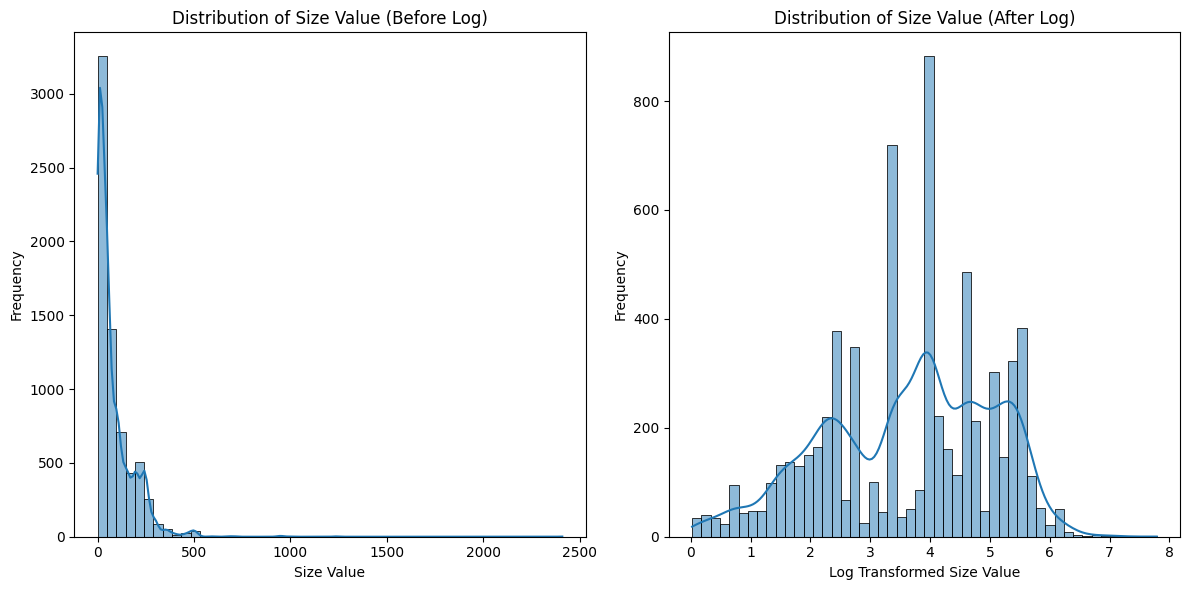

In [ ]:
# Visualize skewness of size_value before and after log transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_product['size_value'].dropna(), bins=50, kde=True)
plt.title('Distribution of Size Value (Before Log)')
plt.xlabel('Size Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_product['size_value'].dropna()), bins=50, kde=True)
plt.title('Distribution of Size Value (After Log)')
plt.xlabel('Log Transformed Size Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Apply log transformation to 'price_usd' and 'reviews'
df_product['log_loves_count'] = np.log1p(df_product['loves_count'])
df_product['log_price_usd'] = np.log1p(df_product['price_usd'])
df_product['log_reviews'] = np.log1p(df_product['reviews'])
df_product['log_size_value'] = np.log1p(df_product['size_value'])

For RandomForest: Imputing -1 (special char) to log_size_value missing values after log so -1 doesnt impact the log-transformation and skewness issue is alleviated

In [ ]:
# Find rows where 'log_size_value' is NaN
nan_log_size_value_rows = df_product[df_product['log_size_value'].isna()]

# Impute NaN values in 'log_size_value' with -1
df_product['log_size_value'] = df_product['log_size_value'].fillna(-1)

#### Reset Index and exclude all the original features to keep only those transformed features for modelling

In [ ]:
df_product = df_product.reset_index(drop=True)

model_features = df_product.drop(columns=[
    'brand_name',
    'loves_count',
    'reviews',
    'size',
    'variation_type',
    'variation_value',
    'variation_desc',
    'ingredients',
    'price_usd',
    'highlights',
    'primary_category',
    'secondary_category',
    'tertiary_category',
    'size_value',
    'size_unit_exploratory',
    'combined_category'
])

In [ ]:
# try re-order features if free

In [ ]:
model_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8430 entries, 0 to 8429
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   rating                     8430 non-null   float64
 1   limited_edition            8430 non-null   int64  
 2   new                        8430 non-null   int64  
 3   online_only                8430 non-null   int64  
 4   out_of_stock               8430 non-null   int64  
 5   sephora_exclusive          8430 non-null   int64  
 6   child_count                8430 non-null   int64  
 7   unit_Unknown               8430 non-null   int64  
 8   unit_g                     8430 non-null   int64  
 9   unit_ml                    8430 non-null   int64  
 10  unit_unit                  8430 non-null   int64  
 11  brand_name_encoded         8430 non-null   float64
 12  has_rating                 8430 non-null   int64  
 13  has_color                  8430 non-null   int64

In [ ]:
model_features.describe()

,rating,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,unit_Unknown,unit_g,unit_ml,...,has_rating,has_color,has_scent,has_formulation,has_type,combined_category_encoded,log_loves_count,log_price_usd,log_reviews,log_size_value
count,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,...,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000,8430.000000
mean,4.054338,0.070819,0.072242,0.219098,0.073665,0.281257,1.638909,0.194306,0.176157,0.605931,...,0.967141,0.201661,0.003559,0.000593,0.009846,450.475445,9.118410,3.683038,4.530227,2.724577
std,0.903897,0.256537,0.258904,0.413660,0.261241,0.449639,5.396563,0.395689,0.380976,0.488679,...,0.178278,0.401264,0.059552,0.024348,0.098742,267.488752,1.784644,0.707906,1.992622,2.217264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.386294,0.000000,-1.000000
25%,3.921650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,186.000000,8.238735,3.258097,3.135494,1.435085
50%,4.269200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,431.000000,9.209290,3.583519,4.740565,3.433987
75%,4.519900,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,711.000000,10.209804,4.077537,6.008198,4.615121
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,105.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,875.000000,14.152746,7.550135,9.965617,7.787693


## Model Training (XGBoost)

In [ ]:
!pip install shap

####Top Features that influence loves_count

Train, Test, Split and build model

In [ ]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

# Features and target
X = model_features.drop(columns=['log_loves_count'])
y = model_features['log_loves_count']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for regression
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'verbosity': 1
}

# Train model
xgboost_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=0
)

# Predict and evaluate
y_pred = xgboost_model.predict(dtest)

# Calculate RMSE and R-Square
xgboost_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgboost_r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {xgboost_rmse:.4f}")
print(f"XGBoost R-squared: {xgboost_r2:.4f}")

XGBoost RMSE: 0.8972
XGBoost R-squared: 0.7654


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R-squared: {rf_r2:.4f}")

Random Forest RMSE: 0.8951
Random Forest R-squared: 0.7665


In [ ]:
# Baseline prediction: always predict the mean of y_test
y_baseline = np.full_like(y_test, fill_value=np.mean(y_test))
# Calculate RMSE for baseline model
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
print(f"Baseline RMSE (predict mean): {baseline_rmse:.4f}")
print("Min:", y_test.min())
print("Max:", y_test.max())
print("Mean:", y_test.mean())
print("Std Dev:", y_test.std())
print("Median:", y_test.median())

Min: 0.0
Max: 13.89368937582776
Mean: 9.088106489701389
Std Dev: 1.8527763069574876
Median: 9.202959664184373
Baseline RMSE (predict mean): 1.8522


#Verdict


## Model Comparison: XGBoost vs. Random Forest

Based on the evaluation metrics:

- **XGBoost Model:**
  - Test RMSE: 0.8972
  - R-squared: 0.7654
  - The predicted vs actual plot shows a relatively strong alignment with the diagonal red dashed line, indicating that the model's predictions are closely matching the actual values.
  - The residuals distribution for XGBoost has a skewness of -1.2599, indicating a slight leftward skew, and a kurtosis of 15.3195, suggesting the residuals have heavy tails (i.e., the model has some larger residual errors).

- **Random Forest Model:**
  - Test RMSE: 0.8951
  - R-squared: 0.7665
  - The predicted vs actual plot also shows strong alignment, with predictions closely following the red dashed line.
  - The residuals for Random Forest have skewness of -1.5637, slightly more negative than XGBoost, and kurtosis of 13.6031, which is slightly lower than XGBoost, indicating less extreme values in the residuals.

Both models perform significantly better than the baseline model (predicting the mean), which had a Baseline RMSE of 1.8522.

The **Random Forest model** has a slightly lower RMSE (0.8951) compared to the XGBoost model (0.8972), indicating it has slightly better predictive accuracy on the test set.

The **Random Forest model** also has a slightly higher R-squared value (0.7665) compared to the XGBoost model (0.7654), meaning it explains a slightly larger proportion of the variance in the target variable.

**Conclusion:**

Based on these metrics, the **Random Forest model appears to perform slightly better** than the XGBoost model on this dataset for predicting `log_loves_count`.

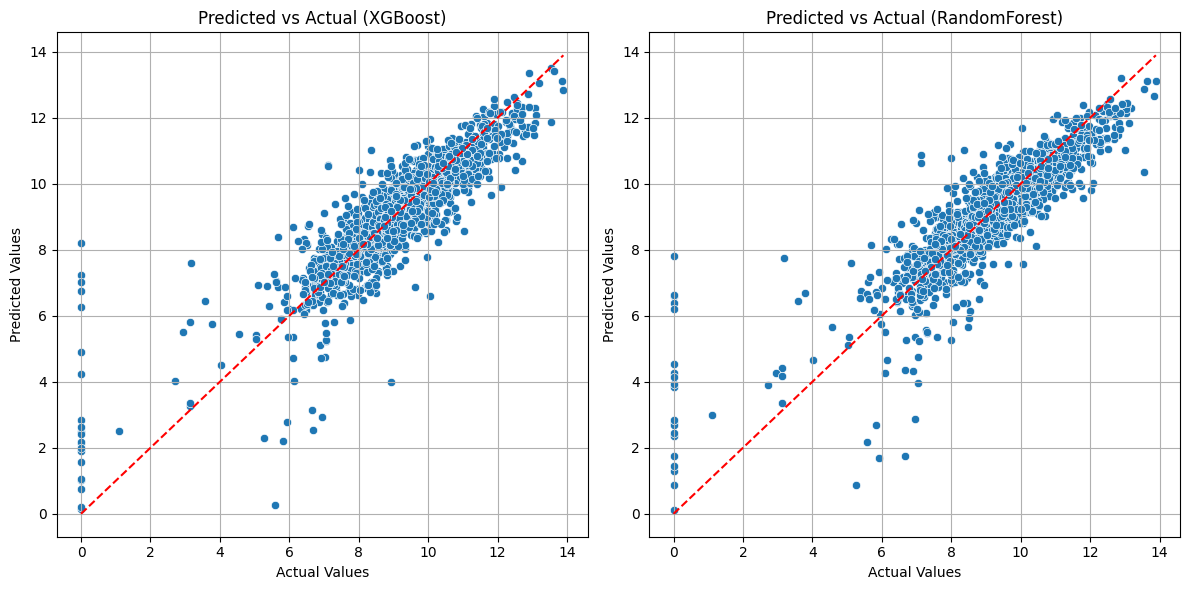

In [ ]:
# Parity plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual (XGBoost)')
plt.grid(True)
# plt.show()

plt.subplot(1, 2, 2)
# plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual (RandomForest)')
plt.grid(True)
# plt.show()

plt.tight_layout()
plt.show()

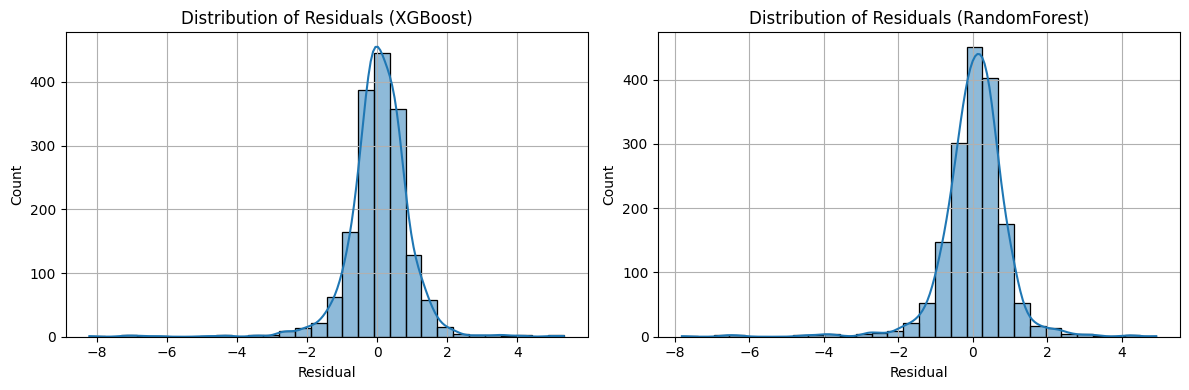

XGBoost Skewness: -1.5299981721456386
XGBoost Kurtosis: 15.319548516391688 

RandomForest Skewness: -1.542621341593943
RandomForest Kurtosis: 13.436121138390849


In [ ]:
#Residuals Distribution Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
residuals = y_test - y_pred
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residual')
plt.title('Distribution of Residuals (XGBoost)')
plt.grid(True)
# plt.show()

plt.subplot(1, 2, 2)
residuals_rf = y_test - y_pred_rf
sns.histplot(residuals_rf, bins=30, kde=True)
plt.xlabel('Residual')
plt.title('Distribution of Residuals (RandomForest)')
plt.grid(True)
# plt.show()

plt.tight_layout()
plt.show()

print("XGBoost Skewness:", skew(residuals))
print("XGBoost Kurtosis:", kurtosis(residuals), "\n")

print("RandomForest Skewness:", skew(residuals_rf))
print("RandomForest Kurtosis:", kurtosis(residuals_rf))

# SHAP Interpretation

Both the XGBoost and Random Forest models captured the same top three most influential features for predicting high loves_count:

* log_reviews
* brand_name_encoded
* child_count

These features show a significant impact on the model outputs, as observed in the SHAP summary plots. For both models, log_reviews exhibits the highest variation in SHAP values, with positive values leading to higher predictions of loves_count. Similarly, brand_name_encoded and child_count also display strong influences, with varying degrees of effect as the feature values change.

The relationship between these features and the model's predictions remains consistent across both models, indicating that they are equally influential in predicting the target variable, loves_count.

However, it’s also worth noting that XGBoost is faster for SHAP value computation, which may be beneficial for larger datasets or when needing rapid interpretation. Despite this, both models share a similar understanding of key features affecting predictions, which can guide further model refinement or feature engineering.

SHAP Summary Plot for XGBoost Model (Top 25% Predicted Loves Count)


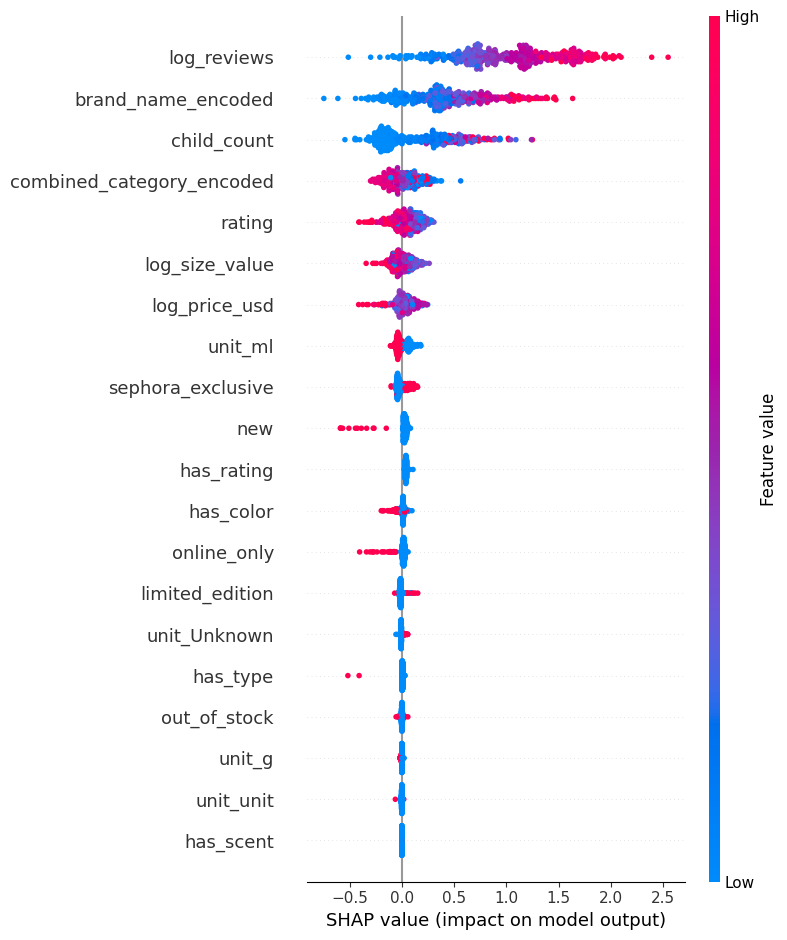

In [ ]:
# Define "high" loves_count threshold (e.g., top 25%)
threshold = np.percentile(y_pred, 75)
high_idx = y_pred >= threshold

# Calculate SHAP values for XGBoost model
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test)

# Filter SHAP values and features for high predictions
shap_high = shap_values[high_idx]
X_high = X_test[high_idx]

# Summary plot only for high predictions
print("SHAP Summary Plot for XGBoost Model (Top 25% Predicted Loves Count)")
shap.summary_plot(shap_high, X_high)

  0%|          | 0/422 [00:00<?, ?it/s]

SHAP Summary Plot for Random Forest Model (Top 25% Predicted Loves Count)


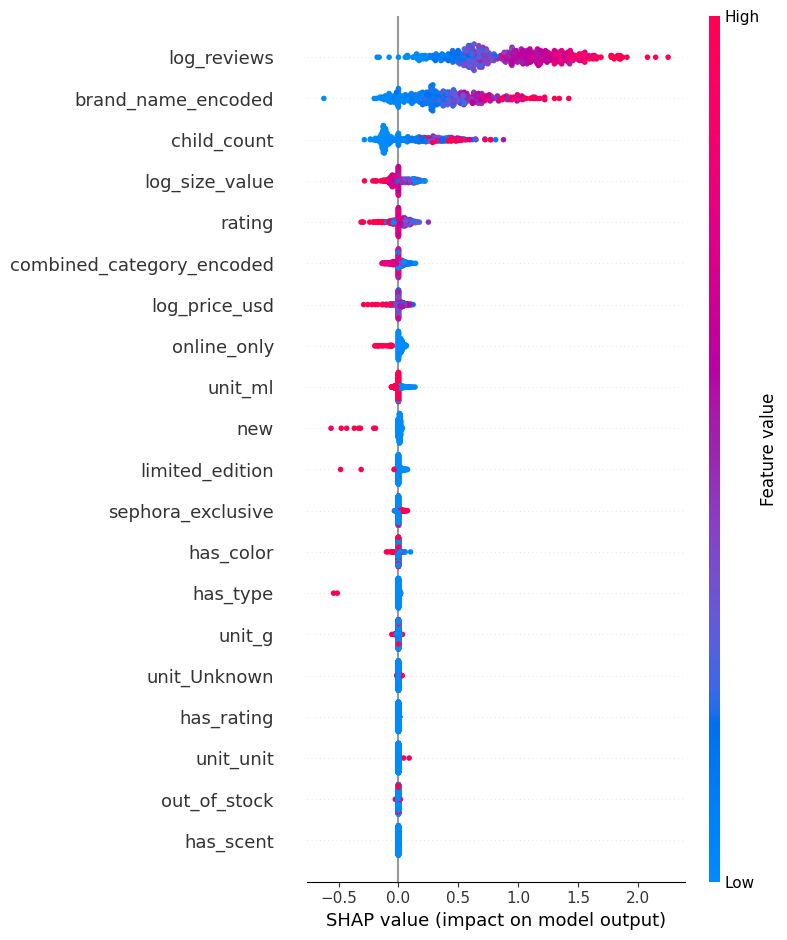

In [ ]:
# Define "high" loves_count threshold based on the top 25% of predictions
threshold = np.percentile(y_pred_rf, 75)
high_idx = y_pred_rf >= threshold

# Filter features (X_test) for high predictions
X_high_rf = X_test[high_idx]

# Calculate SHAP values for the high predictions
explainer_rf = shap.KernelExplainer(rf_model.predict, shap.sample(X_train, 100))
shap_values_rf_high = explainer_rf.shap_values(X_high_rf)

# SHAP summary plot for feature importance on high predictions
print("SHAP Summary Plot for Random Forest Model (Top 25% Predicted Loves Count)")
shap.summary_plot(shap_values_rf_high, X_high_rf)

## Business Objective - Recommendations

Objective: Identify factors that influence loves counts of product e.g. category, brand, ratings, price, size in order to optimize product features or marketing strategies.

1.   Improve the number of reviews
     * Prompt users to leave reviews (email reminders, loyalty rewards)
     * Incentivise reviews for new or undermarketed/underexposed products
     * Highlight review counts in product page to prompt users to like the product
     * Potentially could do a log_reviews target to find out what contributes to high no. of reviews which will then contribute to high loves count.
2.   Leverage on the popular brands more aggressively
     * Boost coverage on portal homepage
     * Collaboration with influencer or artiste to promote brands with the intention to draw more interactions as popular brands already have their own cult followers
     * Bundle products from popular brand with lesser known/popular ones so as to improves exposure for the lesser known brands and products
     * Potentially can cross-sell similar products from other brand e.g. Because you loved [Brand X], try [Brand Y]
3.   Strategize product development or marketing with product variations
     * Products which are popular but has room for growth (in terms of variants) can be offered with more shades, sizes, types (e.g. mini/travel/full-size, or seasonal colours). This require further analysis per product level to find out the most loved attributes of product base on e.g. Makeup -> face -> Concealor
     * Promote products with many variations in the portal featured page.




#### View Product Distribution by Primary Category

/tmp/ipython-input-3055874115.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product_count', y='primary_category', data=primary_category_counts, palette='viridis')


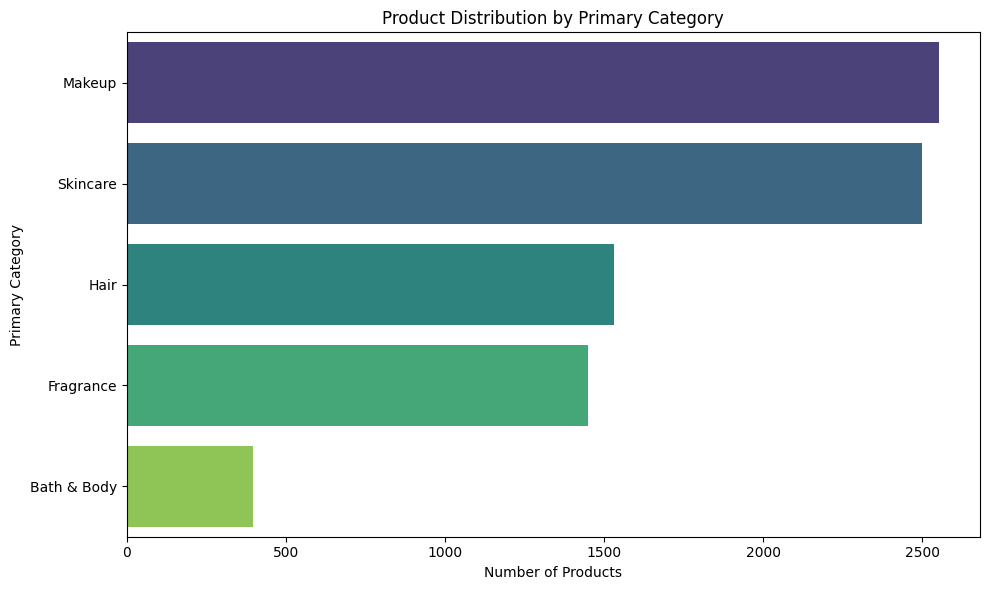

In [ ]:
# Calculate the count of products per primary category
primary_category_counts = df_product['primary_category'].value_counts().reset_index()
primary_category_counts.columns = ['primary_category', 'product_count']

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='product_count', y='primary_category', data=primary_category_counts, palette='viridis')
plt.title('Product Distribution by Primary Category')
plt.xlabel('Number of Products')
plt.ylabel('Primary Category')
plt.tight_layout()
plt.show()

#### View Correlation of Loves Counts vs Rating

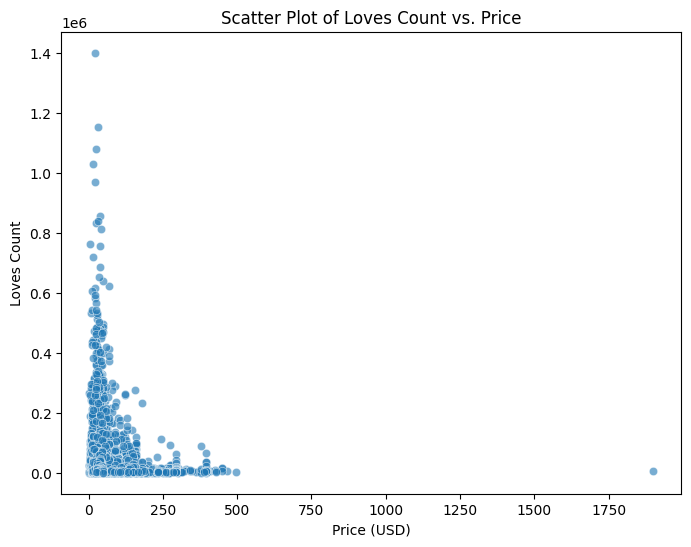

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x='price_usd', y='loves_count', data=df_product, alpha=0.6)
plt.title('Scatter Plot of Loves Count vs. Price') # Reverted title
plt.xlabel('Price (USD)') # Reverted x-label
plt.ylabel('Loves Count') # Reverted y-label
plt.show()

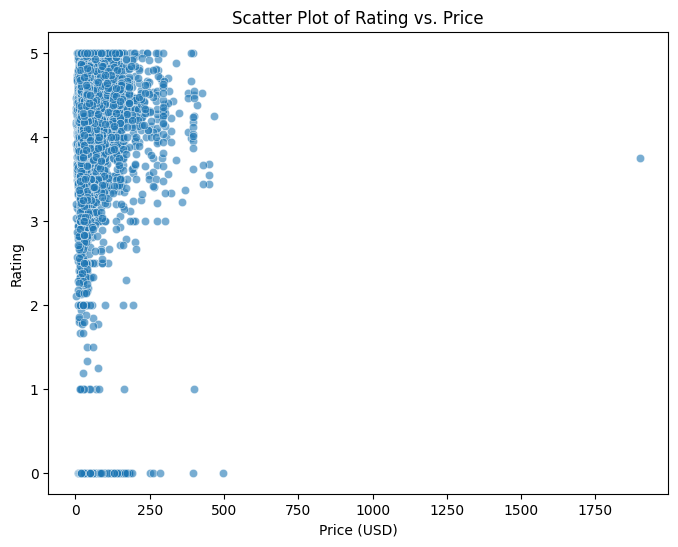

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x='price_usd', y='rating', data=df_product, alpha=0.6)
plt.title('Scatter Plot of Rating vs. Price') # Updated title
plt.xlabel('Price (USD)') # Updated x-label
plt.ylabel('Rating') # Updated y-label
plt.show()

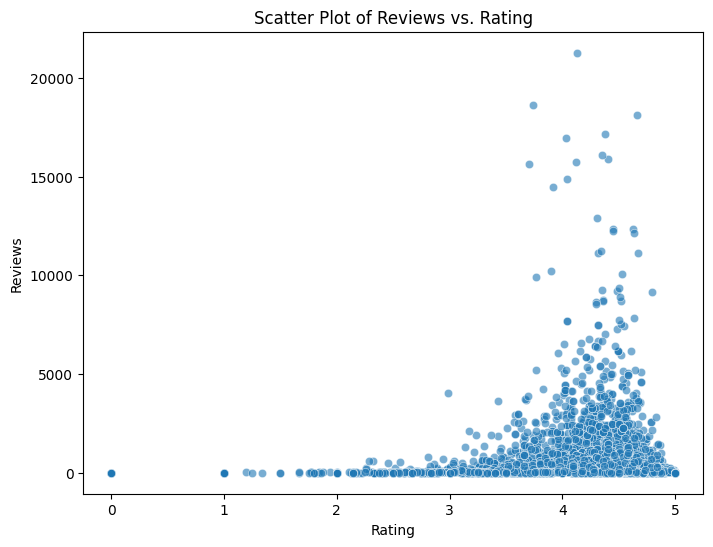

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='reviews', data=df_product, alpha=0.6)
plt.title('Scatter Plot of Reviews vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Reviews')
plt.show()

Correlation between loves_count and rating: 0.09


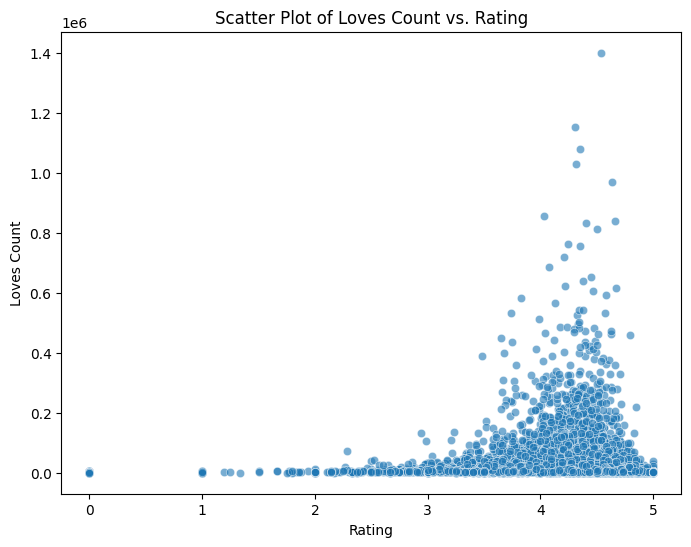

In [ ]:
correlation = df_product['loves_count'].corr(df_product['rating'])
print(f"Correlation between loves_count and rating: {correlation:.2f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='loves_count', data=df_product, alpha=0.6)
plt.title('Scatter Plot of Loves Count vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Loves Count')
plt.show()